# Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока) В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats as stats
from scipy. stats import ttest_ind
sns.set(rc={'figure.figsize': (12,6)}, style="whitegrid")

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Описание данных
1.  reg_ts - дата регистрации пользователя
2.  auth_ts - дата входа пользвателя в игру
3.  uid - уникальный номер пользователя

# 1

Подготовка данных

In [7]:
# загрузка данных о времени регистрации
df_reg=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ta-kim/shared/problem1-reg_data.csv',sep=';')

In [8]:
# загрузка данных о времени захода пользователей в игру
df_auth=pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ta-kim/shared/problem1-auth_data.csv',sep=';')

In [9]:
# объединяем файлы
df_2 = df_reg.merge(df_auth,how='left',on='uid')

In [10]:
# преобразование столбцов с датами в формат даты 
df_2['reg_ts'] = pd.to_datetime(df_2.reg_ts,unit='s').dt.date
df_2['auth_ts'] = pd.to_datetime(df_2.auth_ts,unit='s').dt.date

In [12]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   reg_ts   object
 1   uid      int64 
 2   auth_ts  object
dtypes: int64(1), object(2)
memory usage: 293.0+ MB


In [6]:
df_2.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [16]:
#проверка на пропуски
df_2.isnull().sum()

reg_ts       0
uid          0
auth_ts      0
diff_days    0
dtype: int64

In [17]:
#проверка на дубли
df_2.duplicated().sum()

0

In [7]:
#первая и последняя дата
df_2[['reg_ts','auth_ts']].agg(['min','max'])

,reg_ts,auth_ts
min,1998-11-18,1998-11-18
max,2020-09-23,2020-09-23


In [8]:
# переводим  в datetime64[ns]
df_2['auth_ts'] = pd.to_datetime(df_2['auth_ts'])
df_2['reg_ts'] = pd.to_datetime(df_2['reg_ts'])

In [9]:
df_2.dtypes #datetime

reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

# 2

In [56]:
def retention_day(df, start, end):
    """
    Ретеншен рассчитывается по дневным когортам и дневным интервалам.
    
    параметры:
    ----------
    df:    набор данных в формате pd.DataFrame с обязательными колонками df['reg_ts'] и df['auth_ts']
    start: начало периода за который необходимо рассчитывать ретеншен, формат str,пример('2020-08-23')
    end: конец периода за который необходимо рассчитывать ретеншен, формат str, пример('2020-09-23')
    
    Функция вернет таблицу с диапазоном в 31 день и количеством уникальных пользователей,
    функция вернет визуализацию в процентах с диапазоном в 31 день
    """
    
    df['diff_days'] = (df['auth_ts'] - df['reg_ts']).dt.days
    cohort_days = df_2.groupby(['reg_ts', 'diff_days'],as_index=False) \
                 .agg({'uid':'nunique'}) \
                 .pivot(index='reg_ts', columns='diff_days', values='uid')[start:end]
    
    retention = cohort_days.divide(cohort_days.iloc[:,0], axis='index')
    plt.figure(figsize=(20,16))
    plt.title('Когортный анализ')
    ax = sns.heatmap(data=retention.iloc[1:31,1:31], annot=True, fmt='.2%',
                     annot_kws = dict(color = 'black',fontsize = 8),
                     linewidth = .5,linecolor = 'white',
                     cbar_kws = dict( extend = 'min',ticks = np.arange(1, 1)),
                     cmap = 'YlGnBu')
                     
    ax.set_yticklabels(retention.index)
    plt.xlabel(' ')
    plt.ylabel(' ')
     
    return cohort_days.iloc[1:31,1:31] 

diff_days,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-25,31.0,69.0,75.0,89.0,83.0,83.0,98.0,58.0,90.0,74.0,...,55.0,56.0,51.0,51.0,69.0,44.0,49.0,50.0,36.0,NaN
2020-08-26,23.0,54.0,66.0,71.0,101.0,103.0,94.0,72.0,68.0,64.0,...,41.0,67.0,51.0,43.0,46.0,44.0,43.0,26.0,NaN,NaN
2020-08-27,26.0,53.0,75.0,82.0,87.0,97.0,90.0,68.0,85.0,85.0,...,73.0,47.0,47.0,61.0,53.0,43.0,23.0,NaN,NaN,NaN
2020-08-28,32.0,72.0,83.0,75.0,99.0,98.0,86.0,88.0,83.0,76.0,...,69.0,74.0,64.0,45.0,58.0,40.0,NaN,NaN,NaN,NaN
2020-08-29,40.0,59.0,73.0,90.0,87.0,110.0,90.0,72.0,95.0,68.0,...,70.0,67.0,55.0,56.0,27.0,NaN,NaN,NaN,NaN,NaN
2020-08-30,29.0,55.0,62.0,85.0,94.0,104.0,88.0,68.0,68.0,82.0,...,57.0,64.0,59.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-31,29.0,58.0,67.0,81.0,109.0,103.0,106.0,76.0,85.0,80.0,...,63.0,44.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,32.0,65.0,67.0,73.0,102.0,89.0,102.0,65.0,86.0,81.0,...,69.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-02,40.0,62.0,74.0,90.0,99.0,113.0,100.0,77.0,65.0,90.0,...,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


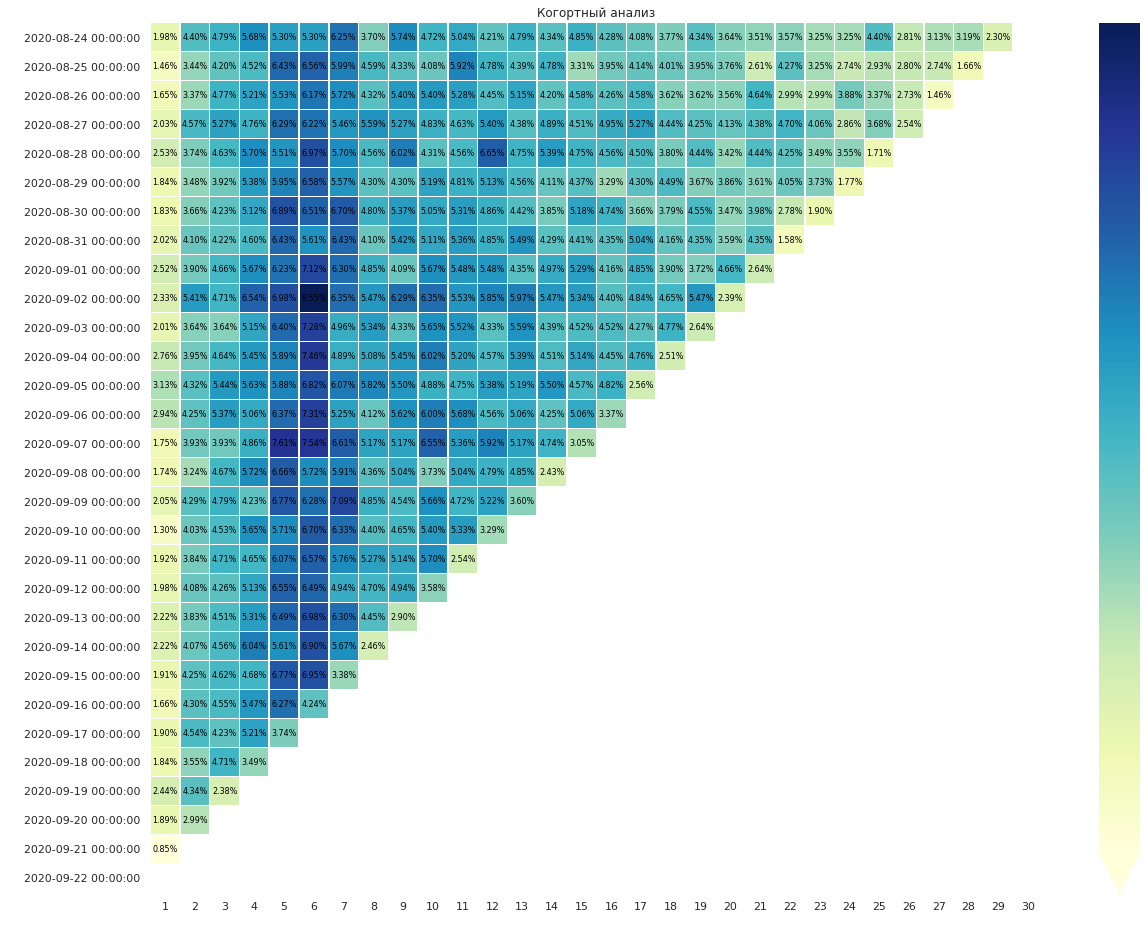

In [57]:
retention_day(df_2,'2020-08-24', '2020-09-23')

In [14]:
help(retention_day)

Help on function retention_day in module __main__:

retention_day(df, start, end)
    Ретеншен рассчитывается по дневным когортам и дневным интервалам.
    
    параметры:
    ----------
    df:    набор данных в формате pd.DataFrame с обязательными колонками df['reg_ts'] и df['auth_ts']
    start: начало периода за который необходимо рассчитывать ретеншен, формат str,пример('2020-08-23')
    end: конец периода за который необходимо рассчитывать ретеншен, формат str, пример('2020-09-23')
    Функция вернет таблицу с диапазоном в 31 день и количеством уникальных пользователей,
    функция вернет визуализацию в процентах с диапазоном в 31 день



# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

# Описание данных
1. user_id - номер пользователя
2. revenue - выручка пользователя
3. testgroup - группа для тестирования


# 1

Подготовка данных

In [2]:
# загрузка данных
ab_df=pd.read_csv('Проект_1_Задание_2.csv',sep=';')
ab_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [3]:
ab_df.duplicated().sum()

0

# 2
Посмотрим количество наблюдений в тестовой 'b' и контрольной группе 'a'. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [10]:
#кол-во всех пользователей по группам
ab_df.groupby("testgroup",as_index=False).agg({"user_id":"count"})

,testgroup,user_id
0,a,202103
1,b,202667


In [11]:
#кол-во платящих пользователей по группам
ab_df[ab_df['revenue']!=0].groupby('testgroup',as_index=False).agg({"user_id":"count"})

,testgroup,user_id
0,a,1928
1,b,1805


разница 564 и 123 - не значительны

# 3

Выручка по группам

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'group b')

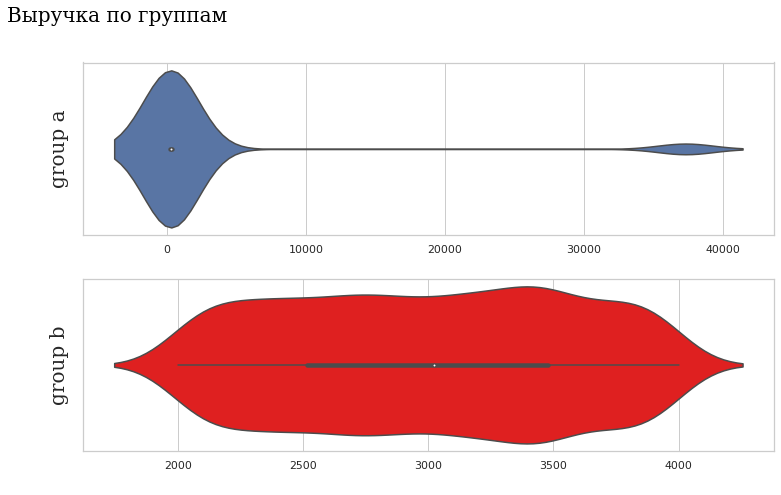

In [12]:
fig = plt.figure(figsize = (12, 3))

ax0 = fig.add_axes([0, 0, 0.8, 0.8])
ax1 = fig.add_axes([0, -1, 0.8, 0.8])
sns.violinplot(ab_df.query("testgroup == 'a' & revenue > 0")['revenue'],ax = ax0,)
sns.violinplot(ab_df.query("testgroup == 'b' & revenue > 0")['revenue'],ax = ax1,color = 'red')  
ax0.set_title(label = 'Выручка по группам',
          color = 'black',
          fontsize = 20,
          x = 0.05,
          y = 1.2,
          family = 'serif')
ax0.set_xlabel(' ')
ax1.set_xlabel(' ')
ax0.set_ylabel('group a',
               fontsize = 20,
               family = 'serif')
ax1.set_ylabel('group b',
               fontsize = 20,
               family = 'serif')


In [13]:
#sum-выручка,count-кол-во пользователей в группах,mean-(arppu)-средний доход на клиента
#min, max 
ab_df[ab_df['revenue']!=0].groupby('testgroup',as_index=False) \
       .agg({'revenue':['sum','count','mean','min','max','median']})

testgroup  revenue                                       
                 sum count         mean   min    max median
0         a  5136189  1928  2663.998444   200  37433    311
1         b  5421603  1805  3003.658172  2000   4000   3022

Результаты анализа выручки:

1. в группе ‘а’ размах выручки в разы больше(min выручка = 200, max выручка = 37433), чем в группе ‘b’ (min выручка = 2000, max выручка = 4000)

2. распределение выручки в группе ‘b’ более равномерно, в группе ‘а’ у пользователей в основном недорогие покупки и небольшая часть очень дорогих покупок.

3. медианная выручка группы ‘b’ (mediana = 3022) примерно в 10 раз больше медианной выручки группы ‘a’ (mediana = 311)


# 4

Конверсии по группам

In [14]:
df_1 = ab_df \
    .groupby([(ab_df['revenue']!=0),(ab_df['revenue']==0),'testgroup'], as_index = False) \
    .agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'}) \
    .sort_values('testgroup') \
    .reset_index(drop = True)
df_1['percent'] = round(df_1['count'][:2] / df_1['count'][:2].sum() * 100, 2)
df_1['percent'][2:] = round(df_1['count'][2:] / df_1['count'][2:].sum() * 100, 2)
df_1

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,testgroup,count,percent
0,a,200175,99.05
1,a,1928,0.95
2,b,200862,99.11
3,b,1805,0.89


теперь проверим статистическую значимость с помощью хи-квадрата.

Н0 гипотеза -  нет связи между двумя наблюдаемыми событиями.

In [15]:
alpha = 0.05
stat,p = stats.chi2_contingency(pd.crosstab(ab_df['testgroup'], ab_df['revenue']!=0))[:2]
if p < alpha:
    print('Н0 отклоняется, p < 0.05')
    print(p.round(4))
else:
    print('Н0 не отклоняется, p > 0.05')
    print(p.round(4))

Н0 отклоняется, p < 0.05
0.0365


итог: 
1. Н0 гипотеза отклонена - различия есть
2. набор акционных предложений для тестовой группы 'а' оказал влияние на желание пользователей совершать более дорогие покупки
3. конверсия в группе 'a'(платящие) больше, чем конверсия в группе 'b'(платящие) на 0.06%. 


# 5

ARPU (ср выручка всех клиентов) и на сколько процентов изменилась средняя выручка в тестовой группе по сравнению с контрольной в %

In [16]:
arpu = round(ab_df.groupby("testgroup",as_index=False).revenue.mean(),2)
arpu

,testgroup,revenue
0,a,25.41
1,b,26.75


In [26]:
#разница ARPU в %
((1 - (arpu.revenue[0] /arpu.revenue[1] )) * 100).round(2)

5.01

ARPPU (средняя выручка всех платящих клиентов) и на сколько процентов изменилась средняя выручка в тестовой группе по сравнению с контрольной в %

In [29]:
arppu = ab_df[ab_df['revenue']>0].groupby("testgroup",as_index=False).revenue.mean().round(2)
arppu

,testgroup,revenue
0,a,2664.00
1,b,3003.66


In [30]:
#разница ARPPU в %
((1 - (arppu.revenue[0] /arppu.revenue[1] )) * 100).round(2)

11.31

итог: показатель ARPU и ARPPU больше в тестовой группе 'b' чем в контрольной 'a' на 5.01% и 11.31%

# 5.1

Теперь посмотрим наши распределения. Проверим выполнение условий на нормальность  в тесте и в контроле.

In [66]:
pg.normality(data=ab_df, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


In [4]:
ab_df.groupby("testgroup").revenue.std()

testgroup
a    920.768137
b    287.324162
Name: revenue, dtype: float64

In [5]:
ab_df.groupby("testgroup").revenue.mean()

testgroup
a    25.413720
b    26.751287
Name: revenue, dtype: float64

итог: 
1.  распределение ненормальное
2.  поэтому логично использовать непараметрический метод, такой как Bootstrap-тест, который не требуют предположений о распределении данных или равенстве дисперсий при большом объеме выборки.

# 5.2

t-критерий Уэлча

H0 гипотеза - разницы между средними выручками (ARPU) группы 'а' и группы 'b' нет

In [73]:
stats.ttest_ind(a=ab_df.query("testgroup == 'b'").revenue, 
             b=ab_df.query("testgroup == 'a'").revenue, equal_var=True)


Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)

t-критерий Уэлча

H0 гипотеза - разницы между средними выручками (ARPPU) группы 'а' и группы 'b' нет

In [74]:
stats.ttest_ind(a=ab_df.query("testgroup == 'a' & revenue > 0")['revenue'], 
                b=ab_df.query("testgroup == 'b' & revenue > 0")['revenue'])

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

итог: t-test показал
1.  ARPU(ср выручка всех пользователей) - H0 гипотеза не отклонена - различий нет
2.  ARPPU(cр выручка платящих пользователей) - H0 гипотеза не отклонена - различий нет

# 5.3

Теперь проверим равенство средних с помощью Bootstrap-тест, который также используется, когда данные не соответствуют предположению о нормальном распределении

H0 гипотеза - разницы между средними выручками (ARPU) группы 'а' и группы 'b' нет

In [56]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print('p-value = ', p_value)
    
boot_data_mean = get_bootstrap(
    data_column_1 = ab_df.query("testgroup == 'a'")['revenue'], 
    data_column_2 = ab_df.query("testgroup == 'b'")['revenue'], 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95)    

p-value =  0.5312148141960059


Bootstrap-тест

H0 гипотеза - разницы между средними выручками (ARPPU) группы 'а' и группы 'b' нет

In [57]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print('p-value = ', p_value)
    
boot_data_mean = get_bootstrap(
    data_column_1 = ab_df.query("testgroup == 'a' & revenue > 0")['revenue'], 
    data_column_2 = ab_df.query("testgroup == 'b' & revenue > 0")['revenue'], 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 )

p-value =  0.10294854837815372


итог: Bootstrap-тест показал
1.  ARPU(ср выручка всех пользователей) - H0 гипотеза не отклонена - различий нет
2.  ARPPU(cр выручка платящих пользователей) - H0 гипотеза не отклонена - различия нет
3.  Различия в акционных наборах не оказали влияние на ARPU и ARPPU.


# 6

Метрики конверсии, выручки, ARPU,ARPPU являются важными при анализе A/B тестирования по нескольким причинам:
1. Конверсия показывает, сколько пользователей прошли определенную цель(например,из авторизации в покупку) и является ключевой метрикой для определения эффективности изменений, внесенных в тестируемую варианту. Чем выше конверсия, тем более успешным можно считать изменения.

2. Выручка: Для бизнеса целью является увеличение выручки. Выручка позволяет оценить эффективность внесенных изменений в виде дополнительного дохода. Повышение выручки часто является одним из главных факторов успеха A/B теста.

3. ARPU и ARPPU: Данные метрики также являются ключевыми для финансового анализа бизнеса. ARPU показывает среднюю выручку, полученную от каждого пользователя (платящих и не платящих вместе), в то время как ARPPU (платящие пользователи). Эти метрики помогают найти более точные и ориентированные данные о доходности изменений.

Результаты анализа метрик: конверсия, выручка, ARPU и ARPPU.

1. Конверсия: учитывая,что статистические различия есть, это указывает на то, что тестовый набор предложений может быть более эффективным для преобразования пользователей в платежеспособных клиентов.

2. Выручка: размах выручки в тестовой группе (от 2000 до 4000) ниже, чем в контрольной группе (от 200 до 37433), однако количество пользователей с высокой выручкой больше в контрольной группе. Это может говорить о том, что контрольный набор предложений может приводить к более крупным платежам, но при этом тестовый набор предложений может обеспечивать стабильную среднюю выручку. необходимо более детально посмотреть, что подходит к вашим бизнес-целям.

3. ARPU (средняя выручка на пользователя): статистических различий нет,это указывают на то, что оба набора предложений дают примерно одинаковые значения ARPU. Это означает, что в среднем пользователи в обеих группах приносят примерно одинаковую среднюю выручку.

4. ARPPU (средняя выручка на платящего пользователя): результаты теста Манна-Уитни указывают на различия в средней выручке на платящего пользователя между тестовой и контрольной группами. Это может указывать на то, что один из наборов предложений способствует более высокой средней выручке на платящего пользователя. Однако, результаты теста bootstrap не подтверждают эти различия. 

По данным результата сложно сделать однозначный вывод
В целом, в принятии правильного решения о лучшем наборе предложений важно учитывать все метрики, а также более детальное прорабатывание бизнес-целей и контекст.
Возможно предложить реализацию тестового набора предложений контрольной группе.

# Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

При оценке результатов последнего прошедшего события в игре Plants & Gardens можно использовать следующие метрики:

1. Количество игроков, принявших участие в событии и количество в обычные дни - позволит оценить популярность и привлекательность события для игроков. Если количество большое, то возможно событие было успешным.

2. Количество игроков, успешно завершивших все требуемые уровни в срок: данная метрика позволит оценить эффективность прохождения уровней и уровень сложности события.

3. Среднее время затраченное на прохождение требуемых уровней - позволит оценить интенсивность и доступность прохождения уровней.

4. Количество полученных уникальных предметов и персонажей - позволит оценить степень привлекательности и ценности наград, которые пользователи могут получить во время события.

5. Выручка от монет и покупок внутри игры - отражает финансовый результат и показывает насколько игроки были готовы совершать покупки внутри игры.

6. Доля активных пользователей во время события - позволяет оценить привлекательность события для пользователей и их активность в нем.

7. Доля повторных сессий во время события - показывает, насколько событие способствует удержанию игроков и их возвращению в приложение.

8. Уровень завершенности события - определяет, сколько игроков смогло успешно завершить все требуемые уровни в рамках заданного времени - показывает, насколько событие было сложным для игроков.

9. Определить в какое время суток наибольшее кол-во игроков, рассчитать среднее число пользователей за час, сравнить показатель с обычными днями.

10. Сравненить среднюю продолжительность сессии в обычный и тематический дни - показывает, как тематическое событие влияет на время, которое игрок проводит в приложении.


Если было внесено изменение в механику событий, где игроки откатываются на несколько уровней назад при неудачной попытке выполнения:

11. Среднее количество неудачных попыток прохождения уровней - позволяет оценить сложность новой механики и то, насколько игрокам требуется времени и усилий для преодоления уровней.

12. Процент откатов игроков на уровни назад - показывает, насколько игроки сталкивались с неудачами и насколько новая механика повлияла на их прогресс в событии.

13. Время, потраченное на прохождение события - позволяет оценить, насколько усложнение механики откатов влияет на онлайн и привлекательность события для игроков. Если игроки тратят больше времени на прохождение, это может быть признаком более сложной игровой механики.

14. Средняя продолжительность игры после неудачной попытки - позволит оценить влияние отката на желания пользователя продолжать    игру.

В реальных условиях выбор метрик может зависеть от целей и ценностей разработчиков игры.
Классификация метрик может быть выполнена по различным критериям, например:

- Метрики роста: количество игроков, выручка от покупок, доля новых пользователей и др.
- Метрики продукта: время проведенное в приложении, средняя продолжительность сессии, конверсия и др.

Определение приоритетов метрик и их классификация должны быть основаны на целях и стратегии развития игры, а также на конкретных потребностях и ожиданиях игроков.